In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'))

In [4]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [5]:
0.8*475

380.0

In [6]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [7]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [ ]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_claims, ar_sentences ,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
        cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
        sentences=articles[ar_id]
        ar_sentences.append(sentences)
        ar_claims.append(cl)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors[:max_sentences]
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'sentences' : np.array(ar_sentences)
                ,'claims': np.array(ar_claims)
                ,'input_headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_claims, ar_sentences ,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[],[],[]
            counter=0
 

In [ ]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [ ]:
x,y = next(test_dg)

In [ ]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

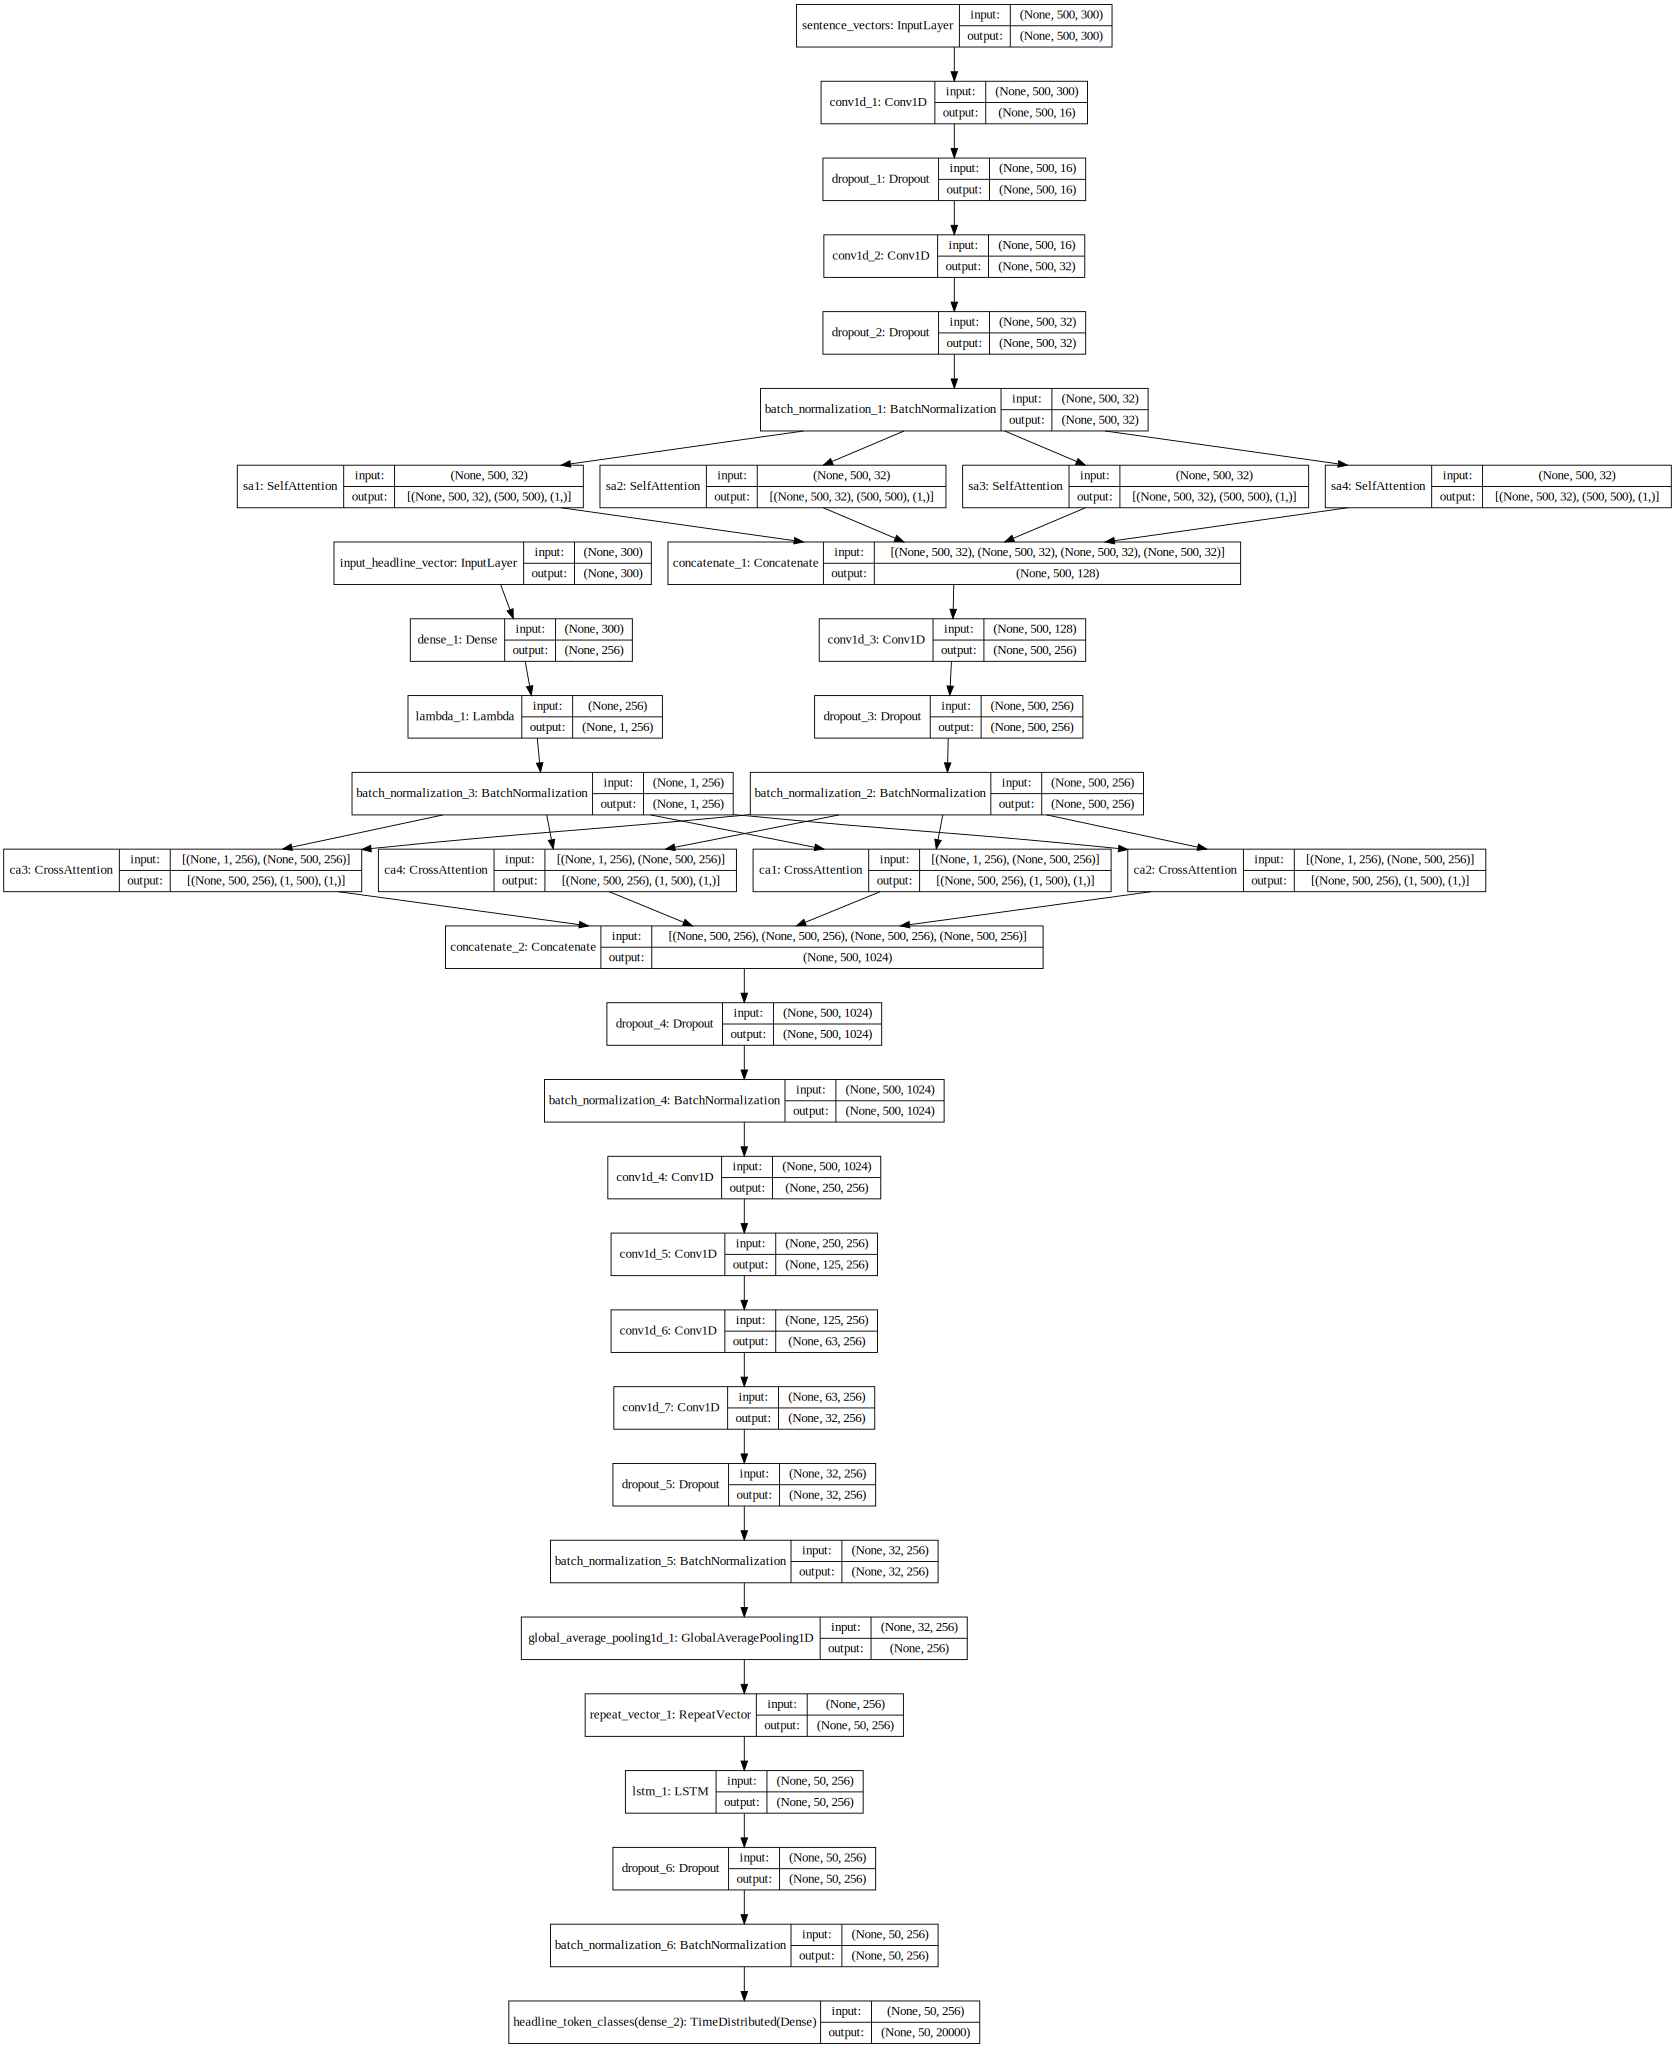

In [9]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
dt = datetime.now()
mc = ModelCheckpoint('weights/cdc_sa_sent_hd_word_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_word_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [ ]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

In [ ]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [ ]:
# df_res = pd.DataFrame(hist.history)

In [ ]:
# df_res[['loss','val_loss']].plot()

In [ ]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [10]:
model.load_weights('weights/cdc_sa_sent_hd_word_gl.hdf5')
# model.evaluate_generator(test_dg,steps=1)

In [ ]:
x,y = next(test_dg)
pred = model.predict(x)
x.keys()

In [11]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [ ]:
test_idx = 0

ar_id = x['article_id'][test_idx]
print(ar_id)
_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [ ]:
b = b1+b2+b3+b4

In [ ]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

In [ ]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:500].sum()

In [ ]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

In [ ]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

In [ ]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [ ]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [ ]:
# nlp.vocab.vectors.data[1282]

In [ ]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [ ]:
# vocab_dict = {}

In [ ]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [ ]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [ ]:
# df_ar_cl_cdc.head()

In [ ]:
# sorted(df_hd_tp_cdc.Title.unique())

In [ ]:
# sorted(df_ar_cl_cdc.Article.unique())

In [ ]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)


In [12]:
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
    print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}

Video game controversies
Brown v. Entertainment Merchants Association
One-child policy
Human population control
Use of performance-enhancing drugs in sport
Physical exercise
Affirmative action
Equal opportunity
Affirmative action in the United States
Boxing
Multiculturalism in the Netherlands
Criticism of multiculturalism
Multicultural education
Gambling
Problem gambling
Economics of gambling
Republicanism in the United Kingdom
Nuclear weapon
Nuclear proliferation
Nuclear peace
Deterrence theory
Abortion debate
Philosophical aspects of the abortion debate
Year-round school
Social safety net
Poverty reduction
Economic inequality
Redistribution of wealth
Atheism
Existence of God
Criticism of religion
The God Delusion
Conscription
Aid effectiveness
Development aid
Aid
Care work
Intellectual property
Libertarian perspectives on intellectual property
Anti-copyright
Philosophy of copyright
Environmental impact of wind power
Biodiversity
Deficit spending
Gun control
Gun politics
Political arg

In [15]:
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.2468085106382979, 0.1029038927975098, 0.14524824553383836)

In [16]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles300[ar_id]
        vectors = article_vectors300[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()
best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.39699999999999996, 0.5396666666666667, 0.45746832740213517)